In [ ]:
#@markdown # 0. Preparation
#@markdown Connect to the Google Drive and change dir
# 链接google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/
!pip install matplotlib pillow tensorboardX tqdm
!git clone https://github.com/xiong414/FlNAL.git

%cd /content/FlNAL
!nvidia-smi

# 1. Intro to implementation
## 1.1 TokenCut for fine feature
The folder structure is as follow:



```
-- tokencut
  |-- bilateral_solver.py
  |-- dino.py
  |-- get_saliency.py
  |-- object_discovery.py
  \-- utils.py
```
Main function:

As dino's original feature does not accurately/correctly represent the location of the cracks, its attention will focus on the noise at some times. So the dino's feature will be further cut with tokencut. Then a better feature can be obtained for subsequent crack segmentation.




In [ ]:
%cd ./tokencut

!python get_saliency.py --sigma-spatial 8 --sigma-luma 3 --sigma-chroma 3 --vit-arch base --patch-size 8 --out-dir /content/drive/MyDrive/dataset/Denses

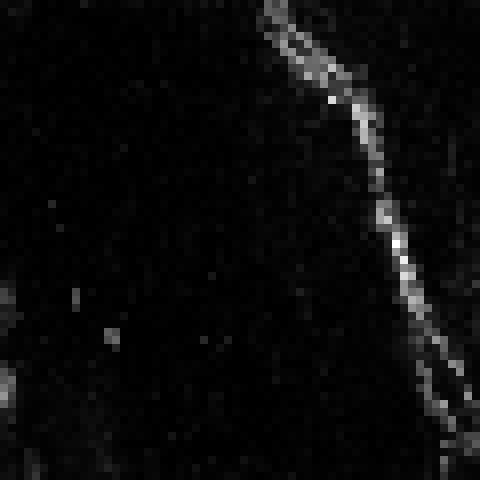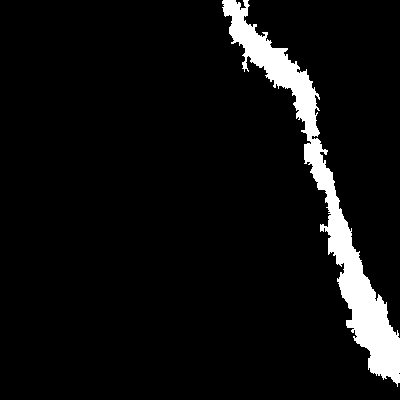

## 1.2 Modified ASPP

The 'modeling' folder structure is as follow:



```
-- modeling
  |-- backbone -- ...
  |-- sync_batchnorm -- ...
  |-- __init__.py
  |-- aspp.py
  |-- aspp_dense.py   # this is the modified ASPP module
  |-- decoder.py
  |-- deeplab.py
  \-- deeplab_dense.py  # this is the deeplab model within modified ASPP
```


Comparison between the ASPP and modified ASPP:

in the '__init__' function:

```
# the old one:
  self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
  self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
  self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
  self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

# the new one:
  self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
  self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
  self.aspp3 = _ASPPModule(inplanes + 256, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
  self.aspp4 = _ASPPModule(inplanes + 512, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

```

in the forward function:

```
# the old one:

def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

# the new one:

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x2_x = torch.cat((x, x2), dim=1)
        x3 = self.aspp3(x2_x)
        x2_x_x3 = torch.cat((x, x2, x3), dim=1)
        x4 = self.aspp4(x2_x_x3)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

```

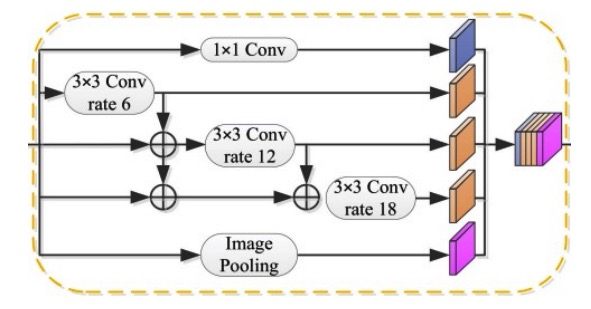



## 1.3 Mixed loss

    def MixedLoss(self, logit, target, gamma=2, alpha=0.5, a=0.1):
        n, c, h, w = logit.size()
        smooth = 1.
        logit = logit.long()/logit.max()
        target = target.long()/target.max()

        # Compute Focal Loss
        criterion_focal = nn.CrossEntropyLoss(weight=self.weight, ignore_index=self.ignore_index,
                                            size_average=self.size_average)
        if self.cuda:
            criterion_focal = criterion_focal.cuda()

        logpt_focal = -criterion_focal(logit, target.long())
        pt_focal = torch.exp(logpt_focal)
        if alpha is not None:
            logpt_focal *= alpha
        focal_loss = -((1 - pt_focal) ** gamma) * logpt_focal

        # Convert logit to one-hot representation
        logit = logit.argmax(dim=1)

        # Compute Dice Coefficient (1 - Dice Loss)
        logit_dice = torch.sigmoid(logit).view(n, -1)
        target_dice = target.view(n, -1)

        intersection = (logit_dice * target_dice).sum(1)
        dice_coeff = (2. * intersection + smooth) / (logit_dice.sum(1) + target_dice.sum(1) + smooth)

        # Compute mixed loss
        mixed_loss = (1 - a) * focal_loss - a * torch.log(1 - dice_coeff)

        if self.batch_average:
            mixed_loss = mixed_loss.mean()

        return mixed_loss

In [ ]:
#@markdown # 2. Training

#@markdown train.sh has 5 different command line to train the model, which is including:
#@markdown - baseline model
#@markdown - .with mixed loss
#@markdown - .with new feature and mixed loss
#@markdown - .with modified ASPP and mixed loss
#@markdown - .with new feature and modified ASPP and mixed loss




In [ ]:
%cd /content/FlNAL
!bash train.sh

/content/FlNAL
Namespace(backbone='resnet_feat', out_stride=16, dataset='crack', use_sbd=False, workers=4, base_size=448, crop_size=448, sync_bn=False, freeze_bn=False, loss_type='focal', epochs=100, start_epoch=0, batch_size=16, test_batch_size=16, lr=0.007, lr_scheduler='poly', momentum=0.9, weight_decay=0.0005, nesterov=False, no_cuda=False, gpu_ids=[0], seed=1, resume=None, checkname='raw_feature_focal_loss', ft=False, eval_interval=1, no_val=False, features=True, featuresnew=False, cuda=True)
Dataloader with Features Loaded
Features Added
Traceback (most recent call last):
  File "/content/FlNAL/train_feat.py", line 292, in <module>
    main()
  File "/content/FlNAL/train_feat.py", line 281, in main
    trainer = Trainer(args)
  File "/content/FlNAL/train_feat.py", line 24, in __init__
    self.train_loader, self.val_loader, self.test_loader, self.nclass = make_data_loader(args, **kwargs)
  File "/content/FlNAL/dataloaders/__init__.py", line 20, in make_data_loader
    train_set =

# 3. Evaluation



In [ ]:
!python3 /content/FlNAL/eval_test.py
# !python3 /content/FlNAL/eval_met.py